# plotting fit results

This notebook runs the function that produces publication ready fit plots

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm.notebook import tqdm

import scripts.plot_tools as pt
import scripts.fit_helpers as fh

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':28,
             'ytick.labelsize':28,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 41975,
  "iopub_port": 60411,
  "stdin_port": 44587,
  "control_port": 40665,
  "hb_port": 35929,
  "ip": "127.0.0.1",
  "key": "a0bf87b9-fd27935b08e480fd10457299",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-8c34ae17-cfed-4edf-aab7-1548fcf70b4d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
plot_labels  = fh.fancy_labels
lut_datasets = pd.read_excel('data/plotting_lut.xlsx', 
                             sheet_name='datasets_2016', 
                             index_col='dataset_name',
                             engine='openpyxl'
                            ).dropna(how='all')

# initialize fit data
scenario = 'unblinded'
infile = open(f'local_data/fit_data_{scenario}.pkl', 'rb')
fit_data = pickle.load(infile)

# get parameter data
parameters = fit_data._parameters
params_pre = parameters['val_init'].values
params_post = parameters['val_fit'].values

# generate label array (same dimension as process amplitudes)
decay_map = fit_data._decay_map
signal_labels = decay_map.decay.tolist()
bg_labels = ['zjets_alt', 'gjets', 'diboson', 'fakes']
labels = 3*signal_labels + signal_labels[-6:] + bg_labels


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


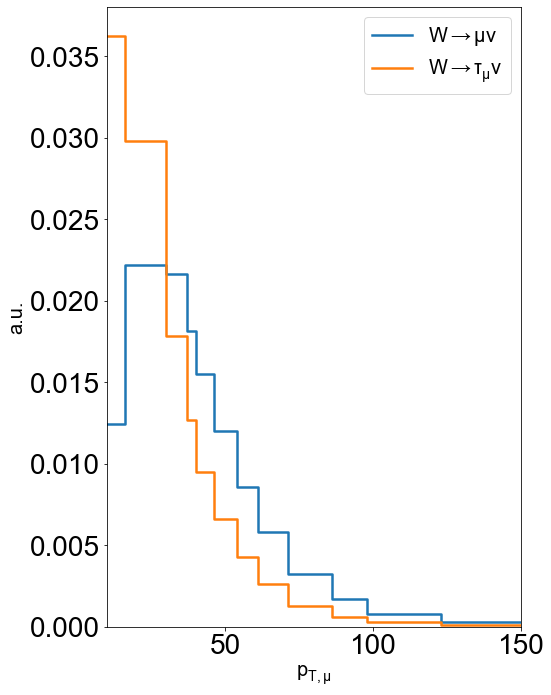

In [3]:
# make overlay of W->mu nu and W->tau nu->mu nu nu
fig, ax = plt.subplots(1, 1, figsize=(8, 10), facecolor='white')

sel = 'mumu'
jet_cat = 'cat_gt2_eq1_b'
template_data = fit_data.get_selection_data(sel)[jet_cat]
templates = template_data['templates']['ttbar']
ttbar_wmu_val, ttbar_wmu_var = templates['wmu_wmu']['val'], templates['wmu_wmu']['var']
ttbar_wtau_val, ttbar_wtau_var = templates['wmu_wtau_mu']['val'], templates['wmu_wtau_mu']['var']
norm_wmu, norm_wtau = ttbar_wmu_val.sum(), ttbar_wtau_val.sum()
bins = template_data['bins']
dx = bins[1:] - bins[:-1]

ax.plot(bins[:-1], ttbar_wmu_val/(norm_wmu*dx), drawstyle='steps-post', label=r'$W\rightarrow \mu\nu$')
ax.plot(bins[:-1], ttbar_wtau_val/(norm_wtau*dx), drawstyle='steps-post', label=r'$W\rightarrow \tau_{\mu}\nu$')
ax.set_ylabel('a.u.')
ax.set_xlabel(r'$p_{T,\mu}$')
ax.set_ylim(0., None)
ax.set_xlim(bins[0], 150.)
ax.legend()

plt.tight_layout()
plt.savefig('plots/muon_pt_shape.pdf')
plt.show()

In [4]:
# make the plots 
yields = dict()
binning_dict = dict()
fit_weights = dict()
gof_test = dict(saturated = 0, chi2 = 0)
nbins = 0
for category, model_data in tqdm(fit_data._model_data.items()):
    
    # parse lepton selection and jet category
    cat_split = category.split('_')
    sel = cat_split[0]
    jet_cat = '_'.join(cat_split[1:])

    # get the data and binning
    template_data = fit_data.get_selection_data(sel)[jet_cat]
    data_val, data_var = template_data['templates']['data']['val'], template_data['templates']['data']['var']
    bins = template_data['bins'][:-1]
    binning_dict[category] = bins
    nbins += bins.size
     
    # build prefit/postfit predictions from model_tensor
    expected_pre, expected_var = fit_data.mixture_model(params_pre, category)
    
    # get template components 
    expected_pre_nosum, _ = fit_data.mixture_model(params_pre, category, no_sum=True)
    expected_post_nosum, _ = fit_data.mixture_model(params_post, category, no_sum=True) # for testing template removal
    bb_np = fit_data._bb_np[category].reshape(1, bins.size).T
    expected_post_nosum *= bb_np
    
    pmask = model_data['process_mask']
    cat_labels = [labels[i] for i in range(pmask.size) if pmask[i]]
    
    df_templates = pd.DataFrame(expected_post_nosum.T, index = cat_labels, columns = bins)
    df_templates.index.name = 'label'
    df_templates.columns.name = 'bins'
    df_templates = df_templates.groupby('label').sum().T
    
    #print(category, cat_labels)
    
    # combined some categories and reorder columns
    ordered_labels = [l for l in pt.fit_plot_labels[sel] if l in df_templates.columns.tolist() + ['other']]
    df_templates['other'] = np.zeros(df_templates.shape[0])
    for label, template in df_templates.iteritems():
        if label in ordered_labels:
            continue
            
        df_templates['other'] += template
        df_templates = df_templates.drop(label, axis=1)
        
    
    # test systematic uncertainties
    ntoys = 10000
    pval, perr = params_pre[4:], parameters['err_init'].values[4:]
    prand = pval + np.random.randn(pval.size, ntoys).T*perr 
    toy_data = np.array([fit_data.mixture_model(np.concatenate([fit_data._beta_init, p]), category)[0] for p in prand]) 
    #toy_data = np.array([td*expected_pre.sum()/td.sum() for td in toy_data])
    toy_data.sort(axis=0)
    median = toy_data[ntoys//2]
    syst_err_pre = (toy_data[int(0.16*ntoys),:]-median, toy_data[-int(0.16*ntoys),:]-median)
    
    pval, perr = params_post[4:], parameters['err_fit'].values[4:]
    prand = pval + np.random.randn(pval.size, ntoys).T*perr 
    toy_data = np.array([fit_data.mixture_model(np.concatenate([fit_data._beta_init, p]), category)[0] for p in prand]) 
    toy_data.sort(axis=0)
    median = toy_data[ntoys//2]
    syst_err_post = (toy_data[int(0.16*ntoys),:]-median, toy_data[-int(0.16*ntoys),:]-median)
    
    #print(category)
    #print(expected_pre)
    #print(syst_err_pre[0])
    #print(syst_err_pre[1])
    #print(syst_err_post[0])
    #print(syst_err_post[1])

    # calculate gof statistics
    histsum = df_templates.sum(axis = 1).values
    gof_test['saturated'] += 2*np.sum(histsum - data_val*(1 - np.log(data_val/histsum)))
    gof_test['chi2'] += np.sum((histsum - data_val)**2/histsum)
    
    df_templates = df_templates[ordered_labels[::-1]]
    pt.fit_plot(df_templates, expected_pre, data_val,
                np.sqrt(expected_var), syst_err_pre, syst_err_post,
                xlabel = plot_labels[sel][0],
                title = f'{plot_labels[sel][1]}: {pt.categories[jet_cat].label}',
                output_path = f'plots/fits/{sel}_{jet_cat}.pdf',
                show = False
               )
    
print(gof_test['saturated'], gof_test['chi2'], nbins)

f = open('local_data/binning.pkl', 'wb')
pickle.dump(binning_dict, f)
f.close()

  0%|          | 0/34 [00:00<?, ?it/s]

296.4029536737191 294.8156969855418 424
